In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This project uses the data from kaggle: https://www.kaggle.com/sid321axn/amazon-alexa-reviews

# 1. Dataset

In [7]:
data = pd.read_csv('amazon_alexa.tsv', delimiter='\t', quoting=3)
print('data shape: {}'.format(data.shape))
data.head(3)

data shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [18]:
#Have a look at a review.
data['verified_reviews'].iloc[100]

'"Great fun getting to know all the functions of this product.  WOW -- family fun and homework help.  Talking with other grandchildren,who also have an Echo, is a HUGE bonus.  Can\'t wait to learn more and more and more"'

In [134]:
data.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

# 2. Text preprocessing

#### remove punctuations and other speacial symbols

In [249]:
#define a function to transform the verified_reviews into standard words.
from nltk.corpus import stopwords
import re
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer

def trans_review(reviews, remove_stops=True, token='Tweet'):
    tokenizer = TweetTokenizer() if token == 'Tweet' else TreebankWordTokenizer()
    stops = set(stopwords.words('english'))#obtain set(stopwords) to save time.
        
    token_sents = []
    for sent in reviews:
        tokens = tokenizer.tokenize(sent)
        tokens = [re.sub('[^a-zA-Z]', ' ', _) for _ in tokens]#keep only the letters.
        tokens = [re.sub('\s+', ' ', _) for _ in tokens]
        tokens = [_.lower() for _ in tokens if _ != ' ']#transform into lower cases.
        if remove_stops:
            tokens = [w for w in tokens if w not in stops]#remove stopwords.
        token_sents.append(tokens)

    return token_sents

In [250]:
trans_review(data['verified_reviews'].iloc[98:100])

[['love'], ['entire', 'family', 'loves', 'alexa', 'echo', 'part', 'family']]

In [268]:
#apply the text preproccessing function to the whole dataframe.
data['clean_review'] = trans_review(data['verified_reviews'])
print(data['clean_review'].iloc[100])
data.head(3)

['great', 'fun', 'getting', 'know', 'functions', 'product', 'wow', 'family', 'fun', 'homework', 'help', 'talking', 'grandchildren', 'also', 'echo', 'huge', 'bonus', 'can t', 'wait', 'learn']


,rating,date,variation,verified_reviews,feedback,clean_review
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,"[love, echo]"
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,[loved]
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,"[sometimes, playing, game, answer, question, c..."


#### Extract the word stems

In [269]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
data['stem_words'] = data['clean_review'].apply(lambda x: [stemmer.stem(word) \
                                                           for word in x])
print('verified review: ', data['verified_reviews'].iloc[100])
print('='*60)
print('clean_review: ', data['clean_review'].iloc[100])
print('='*60)
print('stem_words: ', data['stem_words'].iloc[100])
data.head(3)

verified review:  "Great fun getting to know all the functions of this product.  WOW -- family fun and homework help.  Talking with other grandchildren,who also have an Echo, is a HUGE bonus.  Can't wait to learn more and more and more"
clean_review:  ['great', 'fun', 'getting', 'know', 'functions', 'product', 'wow', 'family', 'fun', 'homework', 'help', 'talking', 'grandchildren', 'also', 'echo', 'huge', 'bonus', 'can t', 'wait', 'learn']
stem_words:  ['great', 'fun', 'get', 'know', 'function', 'product', 'wow', 'famili', 'fun', 'homework', 'help', 'talk', 'grandchildren', 'also', 'echo', 'huge', 'bonu', 'can t', 'wait', 'learn']


,rating,date,variation,verified_reviews,feedback,clean_review,stem_words
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,"[love, echo]","[love, echo]"
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,[loved],[love]
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,"[sometimes, playing, game, answer, question, c...","[sometim, play, game, answer, question, correc..."


#### Visuliaze the frequency of words in reviews

In [257]:
#Frequency of words.
from collections import Counter
import operator

stem_words_list = []
for word in data['stem_words']:
    stem_words_list.extend(word)
count_words = Counter(stem_words_list)

#Sort count_words by value.
count_words = sorted(count_words.items(),\
                     key=operator.itemgetter(1), reverse=True)

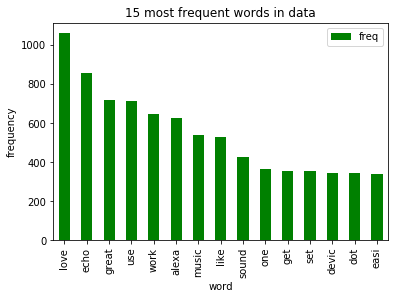

In [258]:
#Plot the most frequent words.
n_plot = 15
count_words_plot = count_words[:n_plot]
df_count_plot = pd.DataFrame(count_words_plot, columns=['word', 'freq'])
df_count_plot.plot(x='word', y='freq', kind='bar', color='g')
plt.xlabel('word')
plt.ylabel('frequency')
plt.title('%d most frequent words in data'%n_plot)
plt.show()

**note** we can see that the most frequent words(except the stopwords: the, we...) are 'love', 'echo', 'great'... which are relatively positive.

# 3. Classification using RandomForest

In this part, we focus on the coluns 'feedback' and use the RandomForestClassifier to try to construct a sentiment classifer.

#### Modelling

In [305]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

X = [' '.join(x) for x in data['stem_words']]
vectorizer = CountVectorizer(min_df=2)
word_vects = vectorizer.fit_transform(X)
print(word_vects.shape)

(3150, 1872)


In [306]:
X_train, X_test, y_train, y_test = train_test_split(word_vects, data['feedback'], test_size=.25, 
                                                   random_state=2020)
print("train dataset's shape: {0}, test dataset's shape: {1}".format(
    X_train.shape, X_test.shape))

train dataset's shape: (2362, 1872), test dataset's shape: (788, 1872)


In [307]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Evaluation

In [308]:
y_pred = rf.predict(X_test)
print('Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred))
print('='*60)
print('Classification Report: ')
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

Confusion Matrix: 
[[ 23  38]
 [  4 723]]
Classification Report: 


,precision,recall,f1-score,support
0,0.851852,0.377049,0.522727,61.000000
1,0.950066,0.994498,0.971774,727.000000
accuracy,0.946701,0.946701,0.946701,0.946701
macro avg,0.900959,0.685774,0.747251,788.000000
weighted avg,0.942463,0.946701,0.937013,788.000000


#### Improvement

Here we want to find the optimal hyperparameters of CountVectorizer and RandomForest to improve the performance.

In [309]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('vectorizer', CountVectorizer()),
                    ('rf', RandomForestClassifier())])
params = {'vectorizer__max_features': [500, 1000, 2000, 5000],
          'vectorizer__min_df': range(1, 4),
         'rf__n_estimators': [50, 100, 200]}
cv = 2

words_train, words_test, y_train, y_test = train_test_split(X, \
                            data['feedback'], test_size=.25, random_state=2020)

search = GridSearchCV(pipeline, params, cv=cv).fit(words_train, y_train)

In [310]:
search.best_params_

{'rf__n_estimators': 100,
 'vectorizer__max_features': 500,
 'vectorizer__min_df': 3}

**note** So we choose n_estimator as 50 and max_features as 100 as our parameters.

In [311]:
clf_rf_optimal = search.best_estimator_
y_pred = clf_rf_optimal.predict(words_test)

In [312]:
pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.800000,0.393443,0.527473,61.000000
1,0.951187,0.991747,0.971044,727.000000
accuracy,0.945431,0.945431,0.945431,0.945431
macro avg,0.875594,0.692595,0.749258,788.000000
weighted avg,0.939484,0.945431,0.936706,788.000000


# 4. Naive Bayes Classifier

In [314]:
from sklearn.naive_bayes import MultinomialNB
piepline = Pipeline([
    ('cv', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB())
])

In [315]:
params = {'cv__min_df': range(1, 5),
    'nb__alpha': [1e-4, 1e-3, 1e-2, 1e-1]}
search = GridSearchCV(piepline, params)
search.fit(words_train, y_train)
search.best_params_

{'cv__min_df': 2, 'nb__alpha': 0.01}

In [316]:
clf_nb_optimal = search.best_estimator_
y_pred_nb = clf_nb_optimal.predict(words_test)
print('Classification Report of Naive Bayes:')
display(pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True)).T)
print('Classification Report of Random Forest:')
display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

Classification Report of Naive Bayes:


,precision,recall,f1-score,support
0,0.857143,0.295082,0.439024,61.000000
1,0.943937,0.995873,0.969210,727.000000
accuracy,0.941624,0.941624,0.941624,0.941624
macro avg,0.900540,0.645478,0.704117,788.000000
weighted avg,0.937219,0.941624,0.928168,788.000000


Classification Report of Random Forest:


,precision,recall,f1-score,support
0,0.800000,0.393443,0.527473,61.000000
1,0.951187,0.991747,0.971044,727.000000
accuracy,0.945431,0.945431,0.945431,0.945431
macro avg,0.875594,0.692595,0.749258,788.000000
weighted avg,0.939484,0.945431,0.936706,788.000000


**note** The Random Forest gets a better f1-score comparing with Naive Bayes.

In this part, we'll focus on the columns 'rating'. There are five different rankings from 1 to 5. Most people have scored 5 which means they are satisfied with the product. The lower the score is, the costumers are less satisfied with the product.

In [137]:
print(data['rating'].value_counts())

5    2286
4     455
1     161
3     152
2      96
Name: rating, dtype: int64


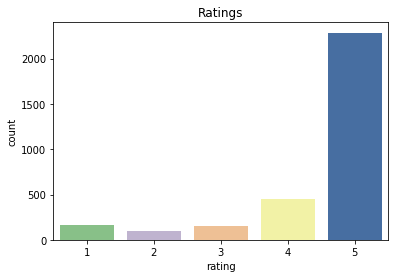

In [142]:
import seaborn as sns
sns.countplot(data['rating'], palette='Accent')
plt.title('Ratings')
plt.show()

In [198]:
#Plot the word frequency of each rating.
data['count_stems'] = data['stem_words'].apply(lambda x: Counter(x.split()))

df_count_group = data.groupby(['rating']).count_stems.sum()

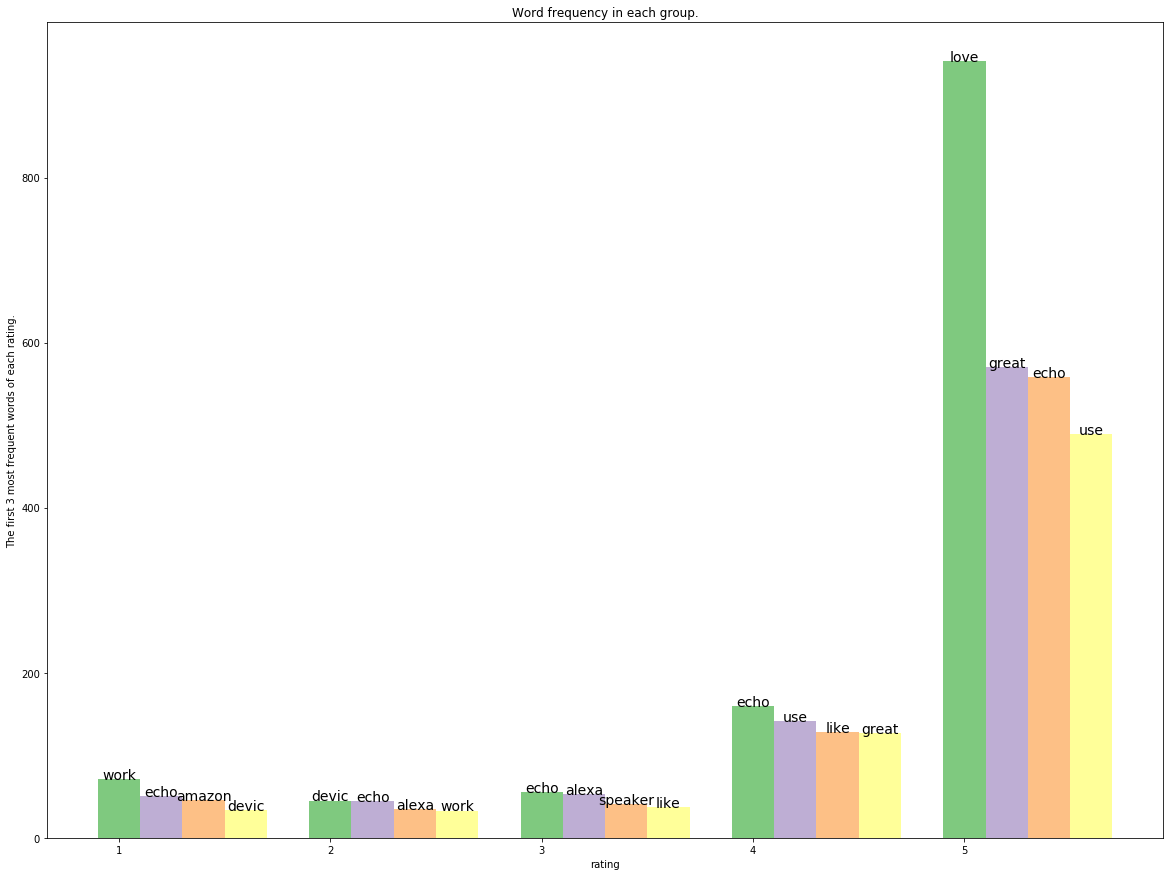

In [220]:
#Plot the first 3 most frequent words of each rating.
max_word_plot = 3
barwidth = 1/(max_word_plot+2)

plt.figure(figsize=(20, 15))
colors = plt.get_cmap('Accent')

for rating, d in enumerate(df_count_group):
    d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    for i, (word, freq) in enumerate(d):
        if i > 3:
            break
        plt.bar(rating+1, freq, width=barwidth, color=colors(i))
        plt.text(rating+1, freq, word, fontsize=14, horizontalalignment='center')
        rating += barwidth
        
plt.xticks(df_count_group.keys())
plt.title('Word frequency in each group.')
plt.xlabel('rating')
plt.ylabel('The first 3 most frequent words of each rating.')
plt.show()